In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests
from urllib.parse import quote
import concurrent.futures

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", message="Glyph .* missing from current font")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

In [3]:
from data_utils import load_data

In [4]:
raw_data = load_data()
raw_data.shape

(145063, 804)

145063 Wikipedia Pages and 803 Days

In [5]:
def extract_page_components(page_name):
    parts = page_name.split('_')
    agent = parts.pop()
    access = parts.pop()
    domain = parts.pop()
    locale = domain.split('.')[0]
    article = '_'.join(parts)
    return article, domain, locale, access, agent

def extract_main_domain(domain):
    if 'wikipedia' in domain:
        return 'wikipedia'
    elif 'wikimedia' in domain:
        return 'wikimedia'
    elif 'mediawiki' in domain:
        return 'mediawiki'
    else:
        return 'other'

raw_data[['article', 'domain', 'locale', 'access', 'agent']] = raw_data['page'].apply(lambda x: pd.Series(extract_page_components(x)))
raw_data['main_domain'] = raw_data['domain'].apply(extract_main_domain)

In [6]:
date_columns = raw_data.filter(regex=r'\d{4}-\d{2}-\d{2}').columns

## Missing Values

**Handling NaNs**: 
  - **NaNs as 0s**: Generally, NaNs can be treated as 0s (no views).
  - **High NaNs**: Articles with NaNs for almost all days should be scrutinized or potentially excluded from analysis.

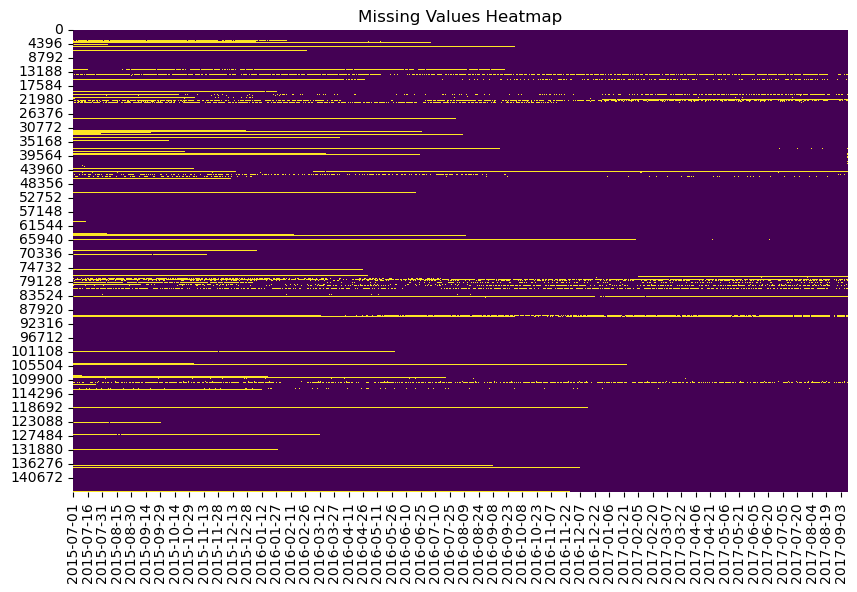

In [7]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(raw_data[date_columns].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

The heatmap visualizes missing values in the dataset. Each row represents an article, and each column represents a date.

1. **Pattern of Missing Values**:
   - Some articles have continuous blocks of missing values.
   - Sparse missing values are scattered across various articles.

2. **Consecutive NaNs at the End**:
   - Many articles have missing values towards the end of the time series, indicating recent data might be incomplete.

3. **Extent of Missing Values**:
   - There is significant variation in the extent of missing data across articles.
   - Some articles have very few missing values, while others have substantial gaps.

### Implications for Analysis
- Articles with significant missing data need special attention during preprocessing.
- Handling missing values (imputation or exclusion) will be crucial for accurate forecasting.

In [8]:
raw_data['total_nans'] = raw_data[date_columns].isna().sum(axis=1)

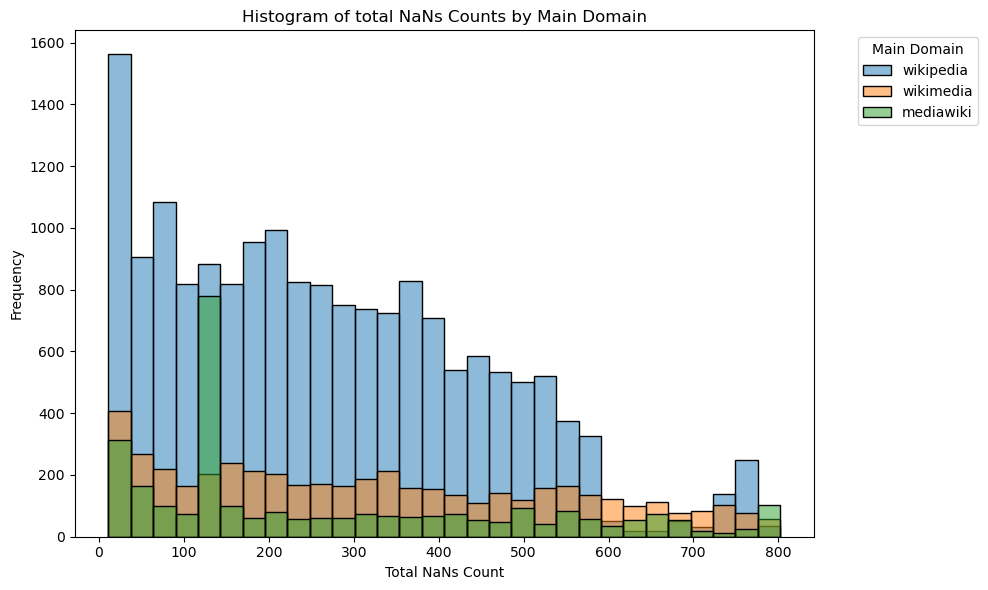

In [9]:
plt.figure(figsize=(10, 6))

main_domains = raw_data['main_domain'].unique()
for main_domain in main_domains:
    subset = raw_data[(raw_data['main_domain'] == main_domain) & (raw_data['total_nans'] > 10)]
    sns.histplot(subset['total_nans'], label=main_domain, kde=False, bins=30, alpha=0.5)

plt.title('Histogram of total NaNs Counts by Main Domain')
plt.xlabel('Total NaNs Count')
plt.ylabel('Frequency')
plt.legend(title='Main Domain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- **General Observation**: All three domains (`wikipedia`, `wikimedia`, `mediawiki`) have NaNs in their view counts.
- **Concern**: A significant number of pages have more than 500 days of NaNs, indicating potential data quality issues for those pages.

In [10]:
rows_to_remove = raw_data[raw_data['total_nans'] > 250]
num_rows_to_remove = len(rows_to_remove)
total_rows = len(raw_data)
proportion_to_remove = num_rows_to_remove / total_rows * 100

print(f"Number of rows to remove: {num_rows_to_remove}")
print(f"Total rows in dataset: {total_rows}")
print(f"Proportion of rows to remove: {proportion_to_remove:.2f}%")

Number of rows to remove: 12423
Total rows in dataset: 145063
Proportion of rows to remove: 8.56%


### Identify Continuous Missing Data (Recently):

Let's first check for consecutive NaNs at the end of each series and exclude those above a certain threshold. This approach ensures to focus on pages with substantial and recent missing data, which could significantly impact the analysis.

* For each page (row), let's count the number of consecutive NaN values at the end of the traffic data columns.
* Let's summarize and analyze the number of consecutive NaNs towards the end to identify potentially inactive pages.

In [11]:
def count_consecutive_nans_at_end(row):
    consecutive_nans = 0
    for value in reversed(row.tolist()):
        if pd.isna(value):
            consecutive_nans += 1
        else:
            break
    return consecutive_nans

raw_data['consecutive_nans_at_end'] = raw_data[date_columns].apply(count_consecutive_nans_at_end, axis=1)

In [12]:
raw_data[raw_data['consecutive_nans_at_end'] > 0]['consecutive_nans_at_end'].describe().to_frame()

,consecutive_nans_at_end
count,5578.000000
mean,46.091789
std,117.155025
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,613.000000


In [13]:
total_articles = len(raw_data)
affected_articles = len(raw_data[raw_data['consecutive_nans_at_end'] > 100])
proportion_affected = affected_articles / total_articles * 100

print(f"Total articles: {total_articles}")
print(f"Articles with more than 100 NaNs at the end of the series: {affected_articles}")
print(f"Proportion: {proportion_affected:.2f}%")

Total articles: 145063
Articles with more than 100 NaNs at the end of the series: 777
Proportion: 0.54%


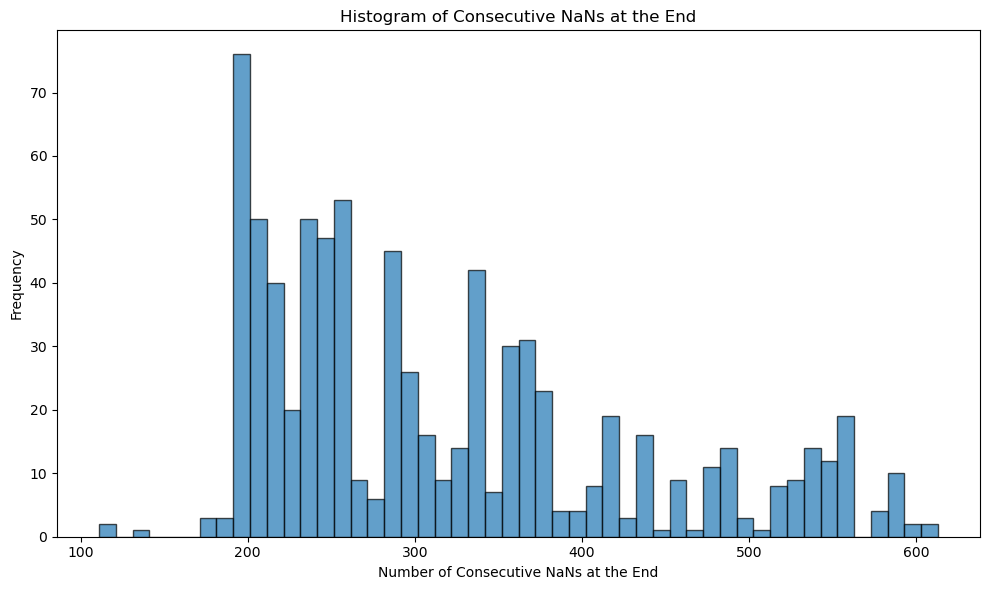

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(raw_data[raw_data['consecutive_nans_at_end'] > 100]['consecutive_nans_at_end'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Consecutive NaNs at the End')
plt.xlabel('Number of Consecutive NaNs at the End')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
raw_data = raw_data[raw_data['total_nans'] <= 0]
raw_data.shape

(115084, 812)

## Distribution of Articles

In [16]:
def visualize_value_counts(df, column, title, horizontal=False, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    if horizontal:
        sns.countplot(data=df, y=column, order=df[column].value_counts().index)
    else:
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    plt.show()

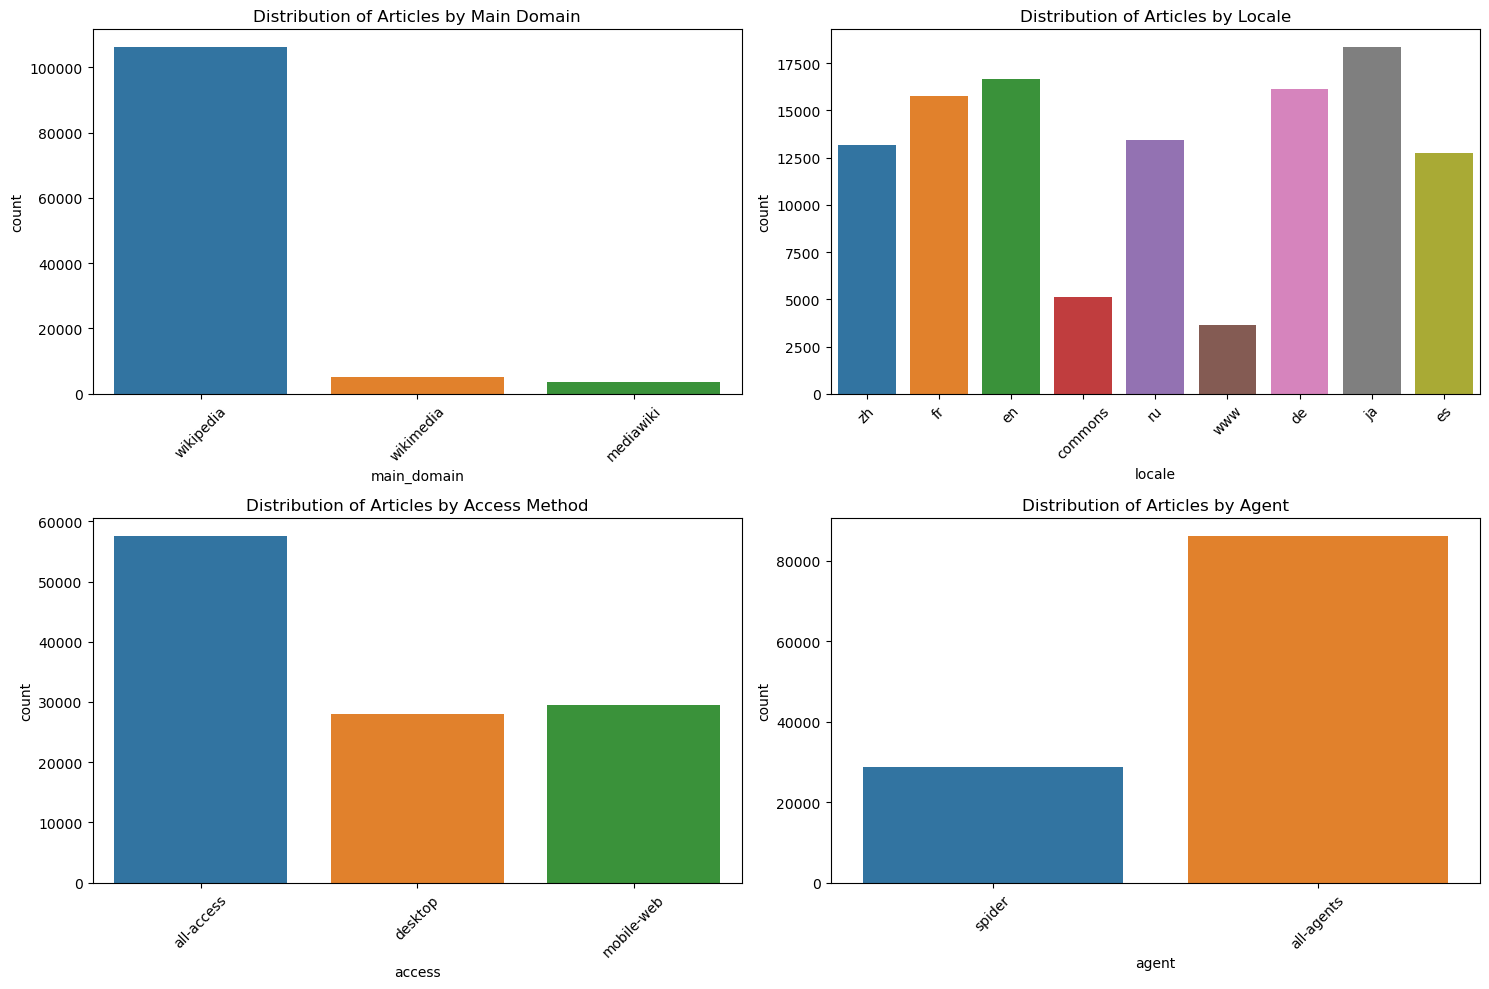

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(data=raw_data, x='main_domain', ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Articles by Main Domain')
axs[0, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=raw_data, x='locale', ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Articles by Locale')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.countplot(data=raw_data, x='access', ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Articles by Access Method')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.countplot(data=raw_data, x='agent', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Articles by Agent')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

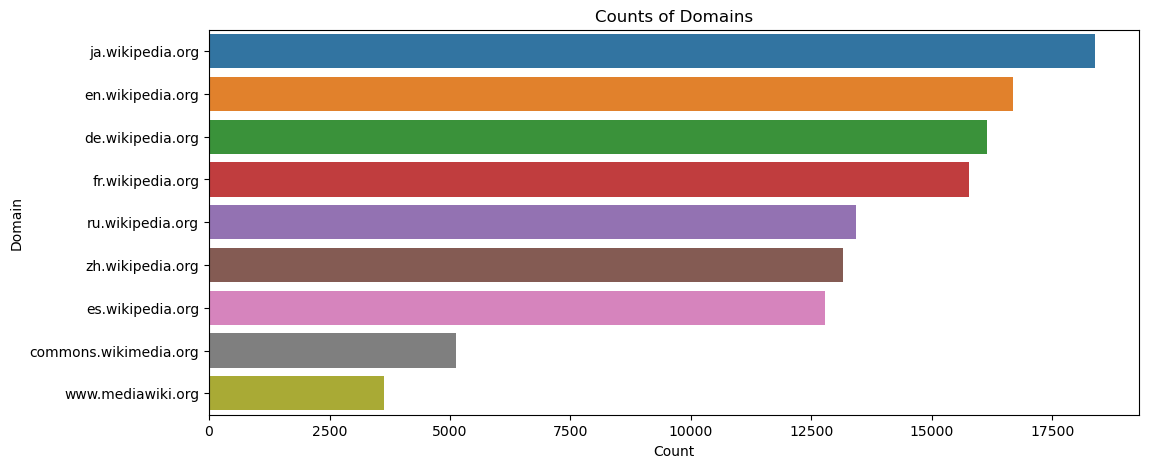

In [18]:
visualize_value_counts(raw_data, 'domain', 'Counts of Domains', horizontal=True, figsize=(12, 5))

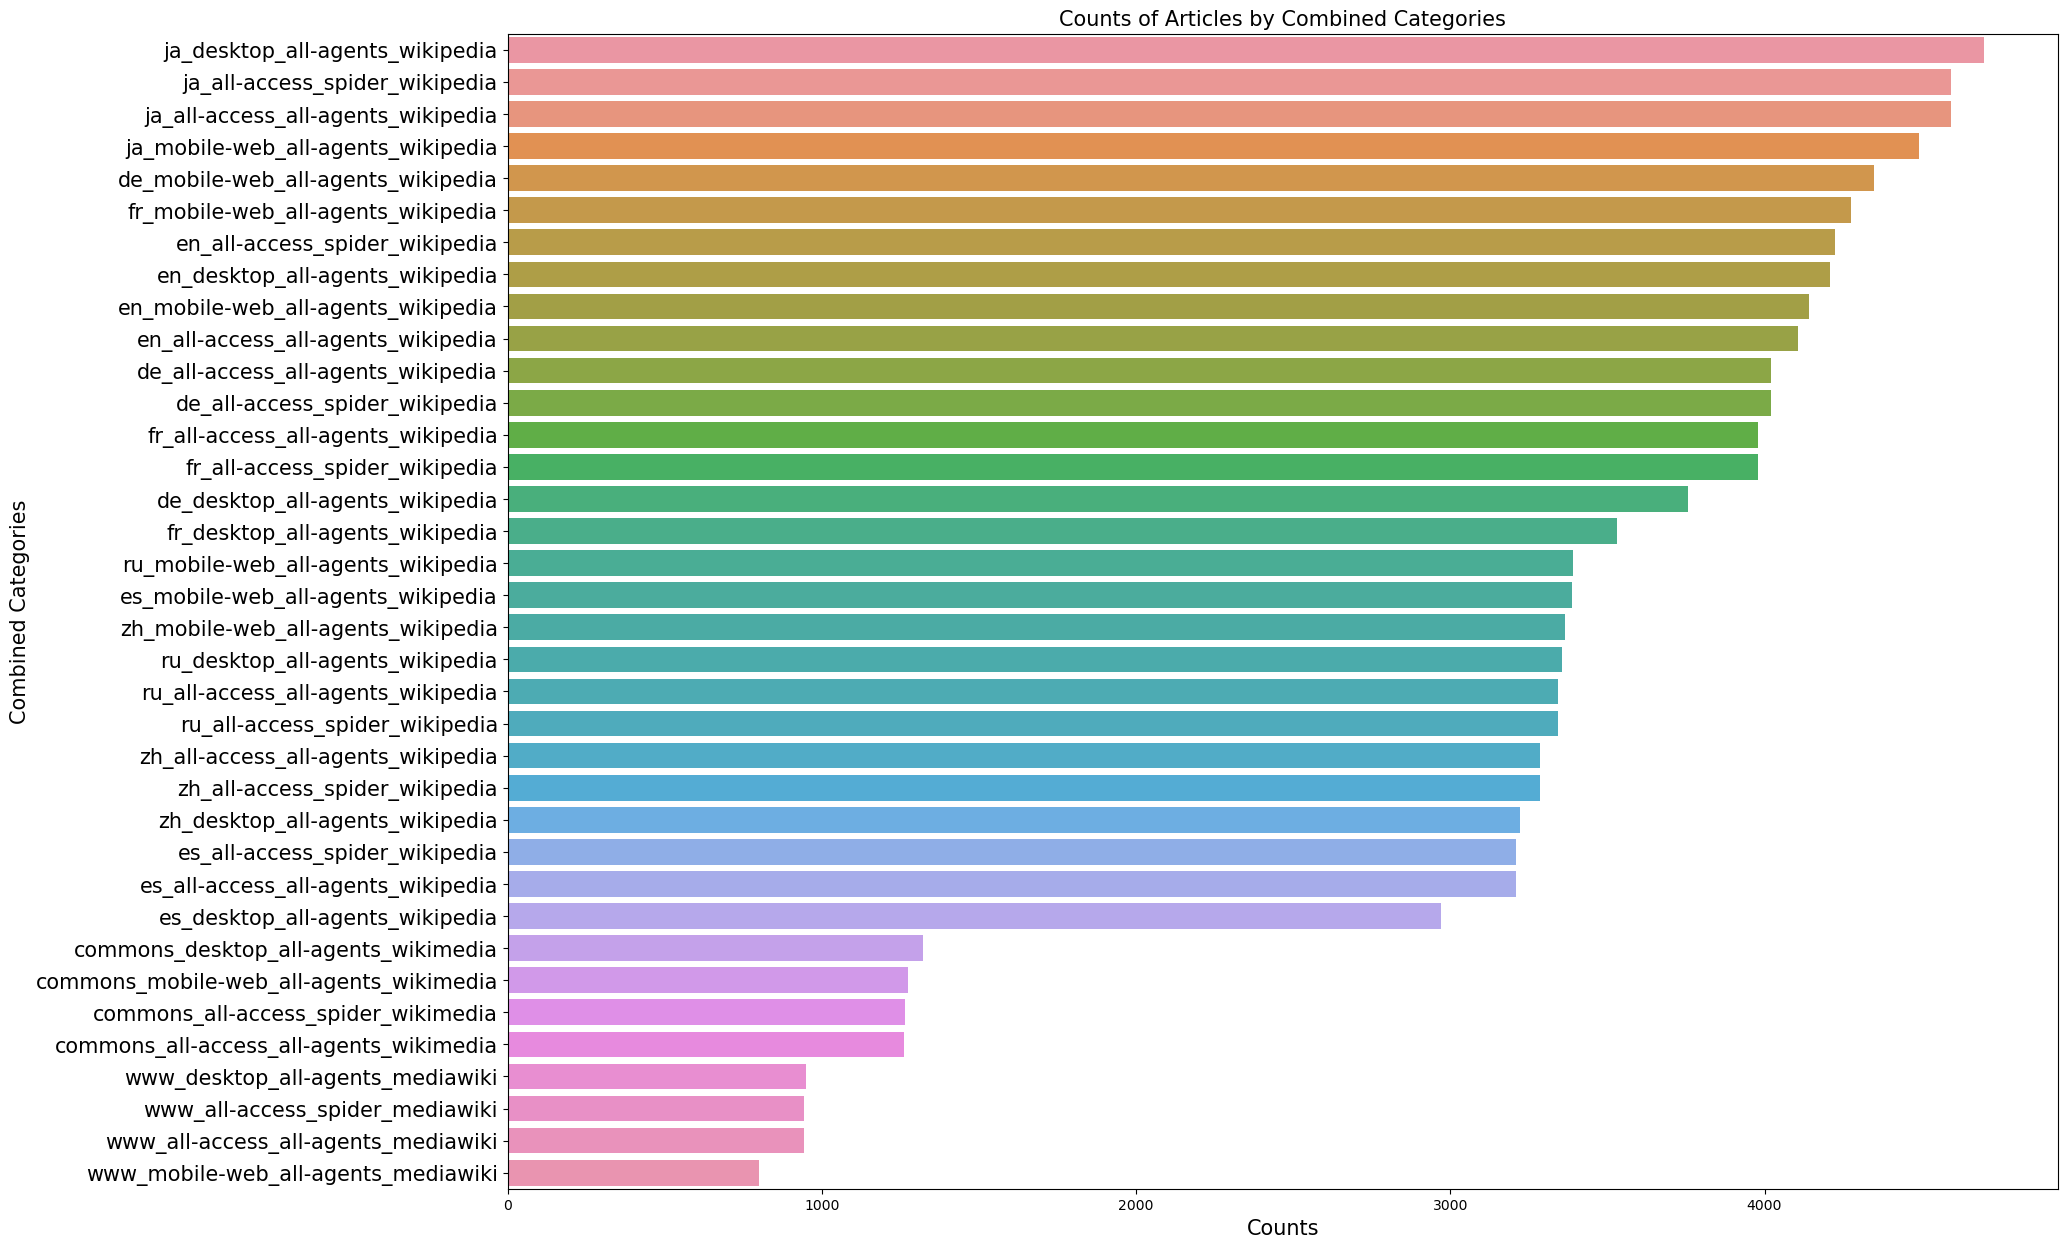

In [19]:
categorical_columns = ['locale', 'access', 'agent', 'main_domain']
grouped_df = raw_data.groupby(categorical_columns).size().reset_index(name='counts')
grouped_df['combined'] = grouped_df.apply(lambda x: f"{x['locale']}_{x['access']}_{x['agent']}_{x['main_domain']}", axis=1)

def plot_grouped_counts(grouped_df, title, figsize=(20, 15), font_size=15):
    plt.figure(figsize=figsize)
    sns.barplot(data=grouped_df, x='counts', y='combined', order=grouped_df.sort_values('counts', ascending=False)['combined'])
    plt.title(title, fontsize=font_size)
    plt.xlabel('Counts', fontsize=font_size)
    plt.ylabel('Combined Categories', fontsize=font_size)
    plt.yticks(fontsize=font_size) 
    plt.show()

plot_grouped_counts(grouped_df, 'Counts of Articles by Combined Categories')

## Distribution of Overall View Counts

In [20]:
date_columns = raw_data.filter(regex=r'\d{4}-\d{2}-\d{2}').columns
all_view_counts = raw_data[date_columns].values.flatten().astype(float)
view_counts = all_view_counts[~pd.isna(all_view_counts)]

In [21]:
description = pd.Series(view_counts).describe()
summary_table = pd.DataFrame(description).transpose()

print('Descriptive Statistics Summary of All the View Counts across all pages (flattened):')
print('******************************************************************')
summary_table

Descriptive Statistics Summary of All the View Counts across all pages (flattened):
******************************************************************


,count,mean,std,min,25%,50%,75%,max
0,92412452.0,1442.241557,89541.839622,0.0,30.0,183.0,705.0,67264258.0


## Distribution of Median View Counts of all Articles

In [22]:
medians = raw_data[date_columns].median(axis=1)
description = medians.describe()

print('Descriptive Statistics Summary of Median View Counts across all pages:')
print('******************************************************************')
summary_table = pd.DataFrame(description).transpose()
summary_table

Descriptive Statistics Summary of Median View Counts across all pages:
******************************************************************


,count,mean,std,min,25%,50%,75%,max
0,115084.0,1134.422109,73780.159641,0.0,29.0,170.0,617.0,19440903.0


The substantial variation in the median view counts of each article across 803 days suggests that there are numerous distinct viewing patterns among the pages. This indicates that while some articles consistently attract a high number of views, others receive significantly fewer, reflecting a diverse range of user interests and behaviors.

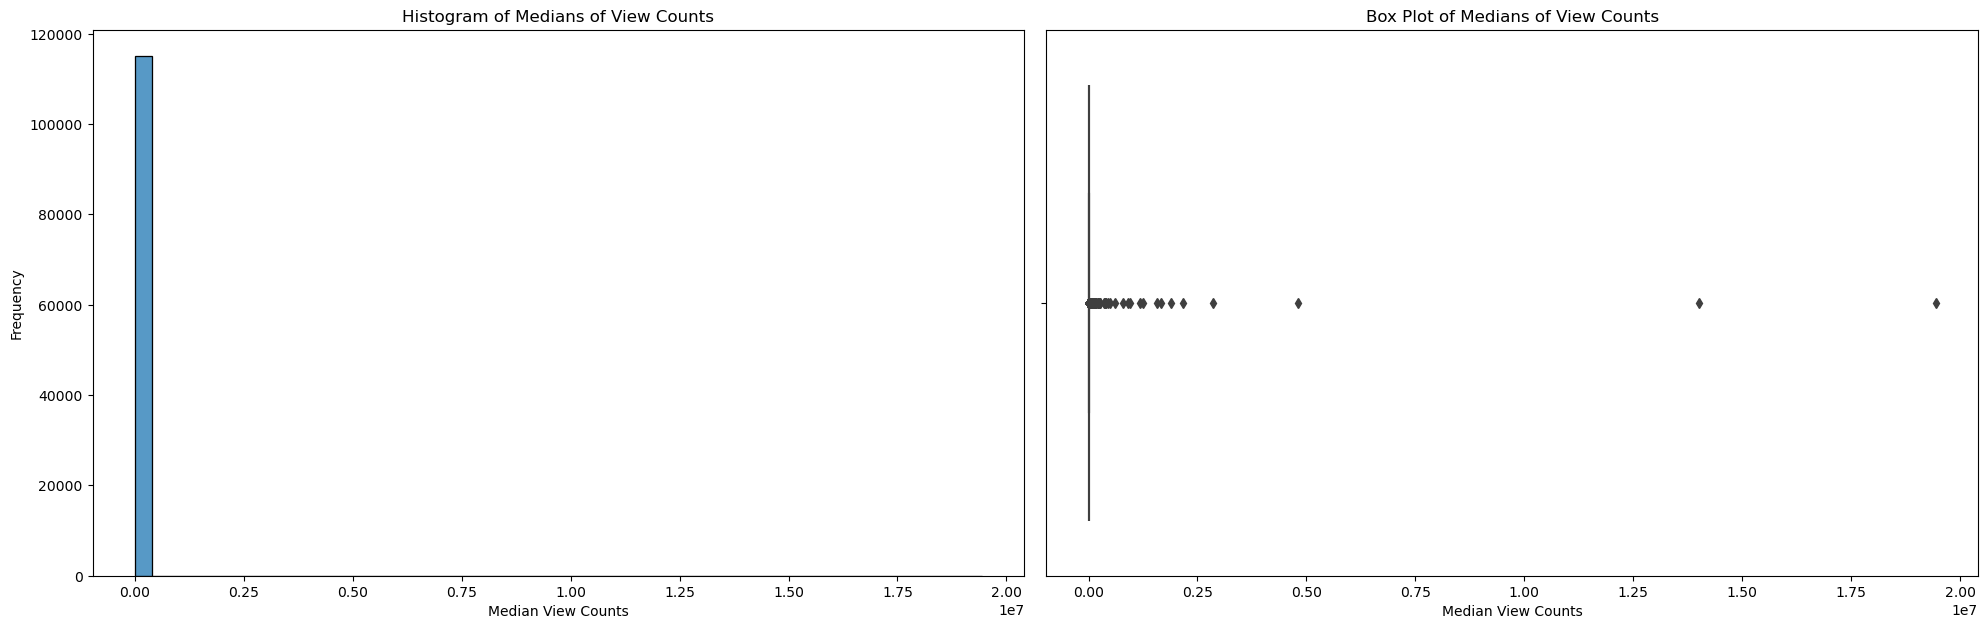

In [23]:
plt.figure(figsize=(20, 12))

# Histogram of Medians
plt.subplot(2, 2, 1)
sns.histplot(medians, bins=50, kde=False)
plt.title('Histogram of Medians of View Counts')
plt.xlabel('Median View Counts')
plt.ylabel('Frequency')

# Box Plot of Medians
plt.subplot(2, 2, 2)
sns.boxplot(x=medians)
plt.title('Box Plot of Medians of View Counts')
plt.xlabel('Median View Counts')


# Show plots
plt.tight_layout()
plt.show()

- Observation: Significant variability in median view counts across articles.
- Hypothesis: This variability might be due to differences in categorical variables.

### Perform ANOVA for Each Categorical Variable

Conduct ANOVA to test the impact of each categorical variable on the median view counts.

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def perform_anova(data, formula):
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table, model.rsquared

raw_data['median_view_count'] = raw_data[date_columns].median(axis=1)
anova_data = raw_data[categorical_columns + ['median_view_count']].copy()

# Individual ANOVA for each categorical variable
anova_results = {}
for column in categorical_columns:
    formula = f'median_view_count ~ C({column})'
    anova_table, r_squared = perform_anova(anova_data, formula)
    anova_results[column] = {
        'anova_table': anova_table,
        'r_squared': r_squared
    }
    print(f'ANOVA results for {column}:')
    print(anova_results[column]['anova_table'])
    print(f'R-squared: {anova_results[column]["r_squared"]:.7f}')

ANOVA results for locale:
                 sum_sq        df         F    PR(>F)
C(locale)  2.058938e+11       8.0  4.729188  0.000008
Residual   6.262498e+14  115075.0       NaN       NaN
R-squared: 0.0003287
ANOVA results for access:
                 sum_sq        df         F    PR(>F)
C(access)  1.775511e+09       2.0  0.163083  0.849521
Residual   6.264539e+14  115081.0       NaN       NaN
R-squared: 0.0000028
ANOVA results for agent:
                sum_sq        df         F    PR(>F)
C(agent)  4.547359e+10       1.0  8.354256  0.003849
Residual  6.264102e+14  115082.0       NaN       NaN
R-squared: 0.0000726
ANOVA results for main_domain:
                      sum_sq        df         F    PR(>F)
C(main_domain)  8.823148e+09       2.0  0.810425  0.444671
Residual        6.264469e+14  115081.0       NaN       NaN
R-squared: 0.0000141


- **Locale**: Statistically significant (p < 0.05) with a higher F-value, but the R-squared value is low, indicating a small effect size.
- **Access**: Not statistically significant (p > 0.05), indicating it does not explain much variance.
- **Agent**: Statistically significant (p < 0.05) with a moderate effect size, but the R-squared value is low.
- **Main_Domain**: Not statistically significant (p > 0.05), indicating it does not explain much variance.

### Perform Combined ANOVA for Interaction Effects

Conduct ANOVA to test the impact of interaction effects between categorical variables on the median view counts.

In [25]:
# Create combined columns for interaction terms
interaction_terms = [
    ('locale', 'access'),
    ('locale', 'agent'),
    ('locale', 'main_domain'),
    ('access', 'agent'),
    ('access', 'main_domain'),
    ('agent', 'main_domain'),
    ('locale', 'access', 'agent'),
    ('locale', 'access', 'main_domain'),
    ('locale', 'agent', 'main_domain'),
    ('access', 'agent', 'main_domain'),
    ('locale', 'access', 'agent', 'main_domain')
]

for terms in interaction_terms:
    combined_column = '_'.join(terms)
    anova_data[combined_column] = anova_data.apply(lambda row: '_'.join([str(row[term]) for term in terms]), axis=1)

# Perform ANOVA for interaction terms
interaction_results = {}
for terms in interaction_terms:
    combined_column = '_'.join(terms)
    formula = f'median_view_count ~ C({combined_column})'
    anova_table, r_squared = perform_anova(anova_data, formula)
    interaction_results[combined_column] = {
        'anova_table': anova_table,
        'r_squared': r_squared
    }
    print(f'ANOVA results for {combined_column}:')
    print(interaction_results[combined_column]['anova_table'])
    print(f'R-squared: {interaction_results[combined_column]["r_squared"]:.6f}')


ANOVA results for locale_access:
                        sum_sq        df         F    PR(>F)
C(locale_access)  2.161420e+11      26.0  1.527349  0.041658
Residual          6.262395e+14  115057.0       NaN       NaN
R-squared: 0.000345
ANOVA results for locale_agent:
                       sum_sq        df         F    PR(>F)
C(locale_agent)  3.175820e+11      17.0  3.433079  0.000002
Residual         6.261381e+14  115066.0       NaN       NaN
R-squared: 0.000507
ANOVA results for locale_main_domain:
                             sum_sq        df         F    PR(>F)
C(locale_main_domain)  2.058938e+11       8.0  4.729188  0.000008
Residual               6.262498e+14  115075.0       NaN       NaN
R-squared: 0.000329
ANOVA results for access_agent:
                       sum_sq        df         F    PR(>F)
C(access_agent)  6.619645e+10       3.0  4.053861  0.006852
Residual         6.263895e+14  115080.0       NaN       NaN
R-squared: 0.000106
ANOVA results for access_main_domain:
      

- The R-squared values are generally very low for both individual and interaction effects, indicating that these categorical variables and their combinations do not explain much of the variability in the median view counts.
- This suggests that other factors or variables not included in this analysis might be influencing the view counts more significantly.

**Conclusion:**
- R-squared Interpretation
R-squared Values: The R-squared values for both individual and interaction effects are generally very low. This indicates that the categorical variables and their combinations do not explain much of the variability in the median view counts.
    - Implication: Other factors or variables not included in this analysis might be influencing the view counts more significantly.

- Statistical Significance vs. Practical Significance
Statistical Significance: Some variables and interactions are statistically significant (p < 0.05).
Practical Significance: Despite statistical significance, the practical contribution to the variability in median view counts is negligible due to very low R-squared values.

- Feature Engineering: Explore feature engineering techniques to create new features that might better capture the underlying patterns in the data.

In [26]:
## Tranpose the data to have index as dates and columns as time series of each pages
df = raw_data[['page'] + date_columns.tolist()].copy()
df.set_index('page', inplace=True)
df = df.T
df.index = pd.to_datetime(df.index)
df.head()

page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,Ahq_e-Sports_Club_zh.wikipedia.org_all-access_spider,All_your_base_are_belong_to_us_zh.wikipedia.org_all-access_spider,...,Transgénero_es.wikipedia.org_all-access_spider,Edad_Contemporánea_es.wikipedia.org_all-access_spider,Salvador_Dalí_es.wikipedia.org_all-access_spider,Soraya_Jiménez_es.wikipedia.org_all-access_spider,Día_Internacional_del_Beso_es.wikipedia.org_all-access_spider,Chichén_Itzá_es.wikipedia.org_all-access_spider,Fecundación_es.wikipedia.org_all-access_spider,Gran_Hermano_VIP_(España)_es.wikipedia.org_all-access_spider,Modelo_atómico_de_Thomson_es.wikipedia.org_all-access_spider,Copa_América_2019_es.wikipedia.org_all-access_spider
2015-07-01,18.0,11.0,1.0,35.0,12.0,118.0,5.0,6.0,2.0,2.0,...,4.0,21.0,23.0,3.0,1.0,8.0,29.0,4.0,0.0,3.0
2015-07-02,11.0,14.0,0.0,13.0,7.0,26.0,23.0,3.0,1.0,5.0,...,3.0,32.0,40.0,7.0,3.0,13.0,16.0,25.0,2.0,10.0
2015-07-03,5.0,15.0,1.0,10.0,4.0,30.0,14.0,5.0,4.0,5.0,...,4.0,38.0,55.0,6.0,8.0,19.0,6.0,7.0,6.0,41.0
2015-07-04,13.0,18.0,1.0,94.0,5.0,24.0,12.0,12.0,4.0,1.0,...,17.0,21.0,32.0,3.0,3.0,14.0,11.0,11.0,6.0,17.0
2015-07-05,14.0,11.0,0.0,4.0,20.0,29.0,9.0,6.0,2.0,3.0,...,28.0,28.0,42.0,3.0,6.0,6.0,33.0,6.0,7.0,16.0


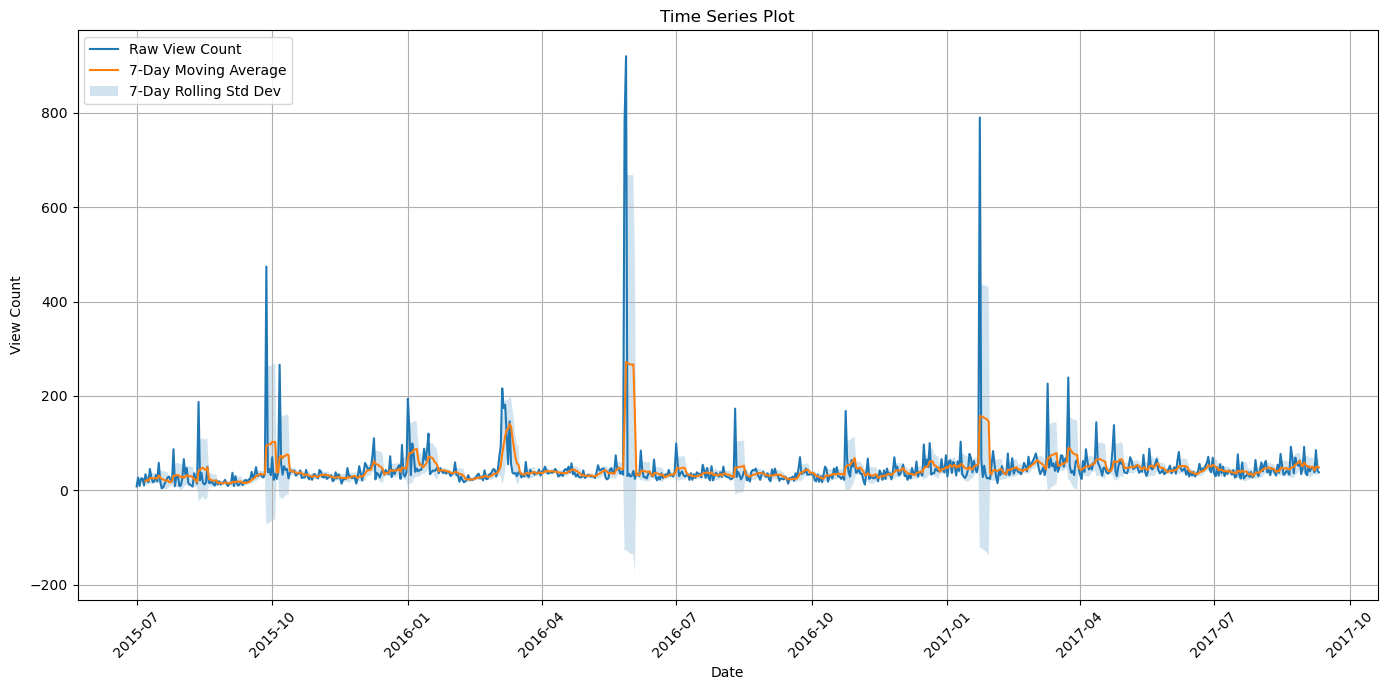

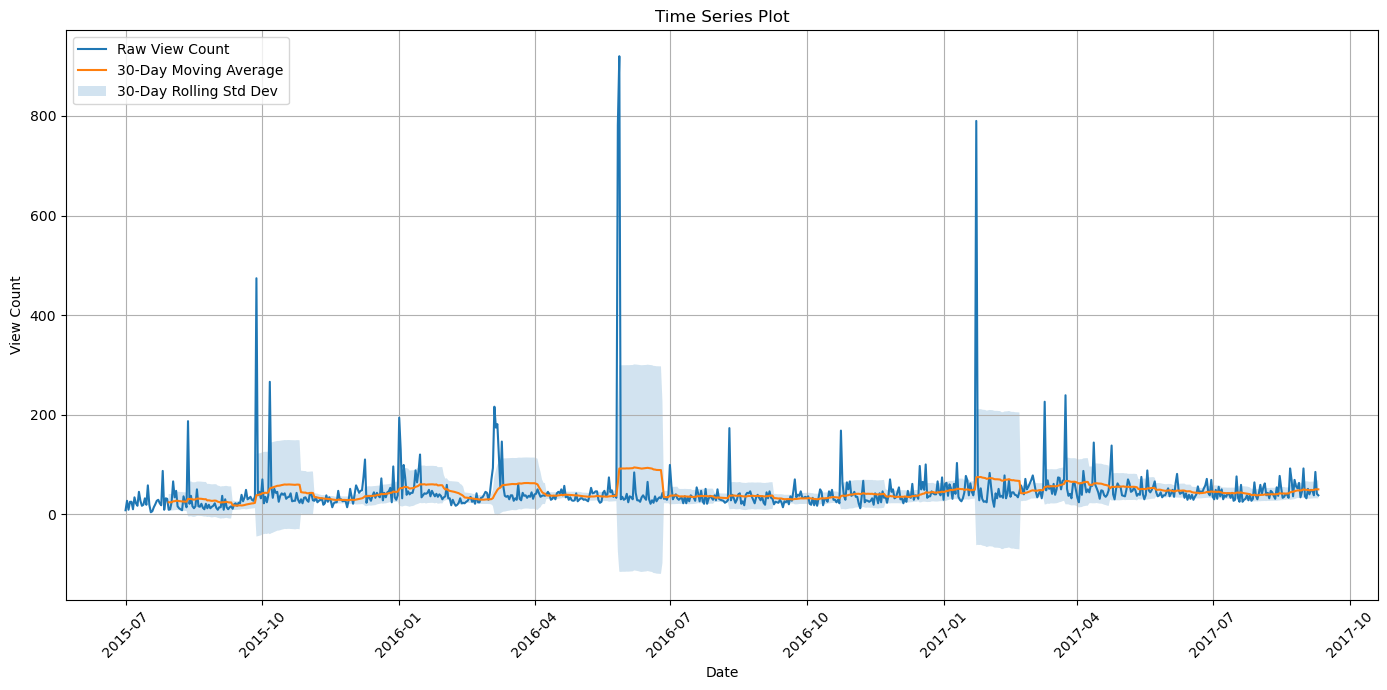

In [27]:
def plot_time_series(time_series, date_columns, window_sizes=[7], title='Time Series Plot'):
    dates = pd.to_datetime(date_columns)
    time_series = pd.Series(time_series, index=pd.to_datetime(dates))
    
    plt.figure(figsize=(14, 7))
    plt.plot(time_series, linestyle='-', label='Raw View Count')

    for window_size in window_sizes:
        rolling_mean = time_series.rolling(window=window_size).mean()
        rolling_std = time_series.rolling(window=window_size).std()
        
        plt.plot(rolling_mean, linestyle='-', label=f'{window_size}-Day Moving Average')
        plt.fill_between(rolling_mean.index, rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.2, label=f'{window_size}-Day Rolling Std Dev')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('View Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_time_series(df.iloc[:, 10], date_columns, window_sizes=[7])
plot_time_series(df.iloc[:, 10], date_columns, window_sizes=[30])

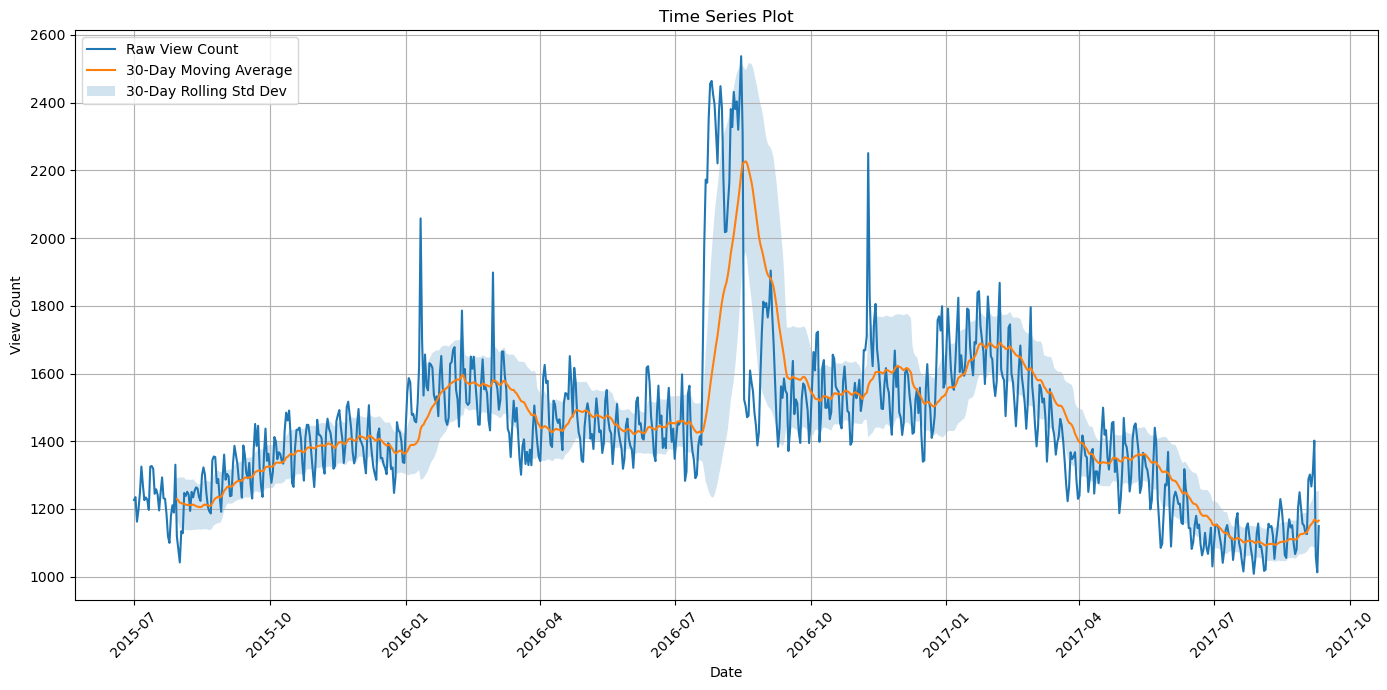

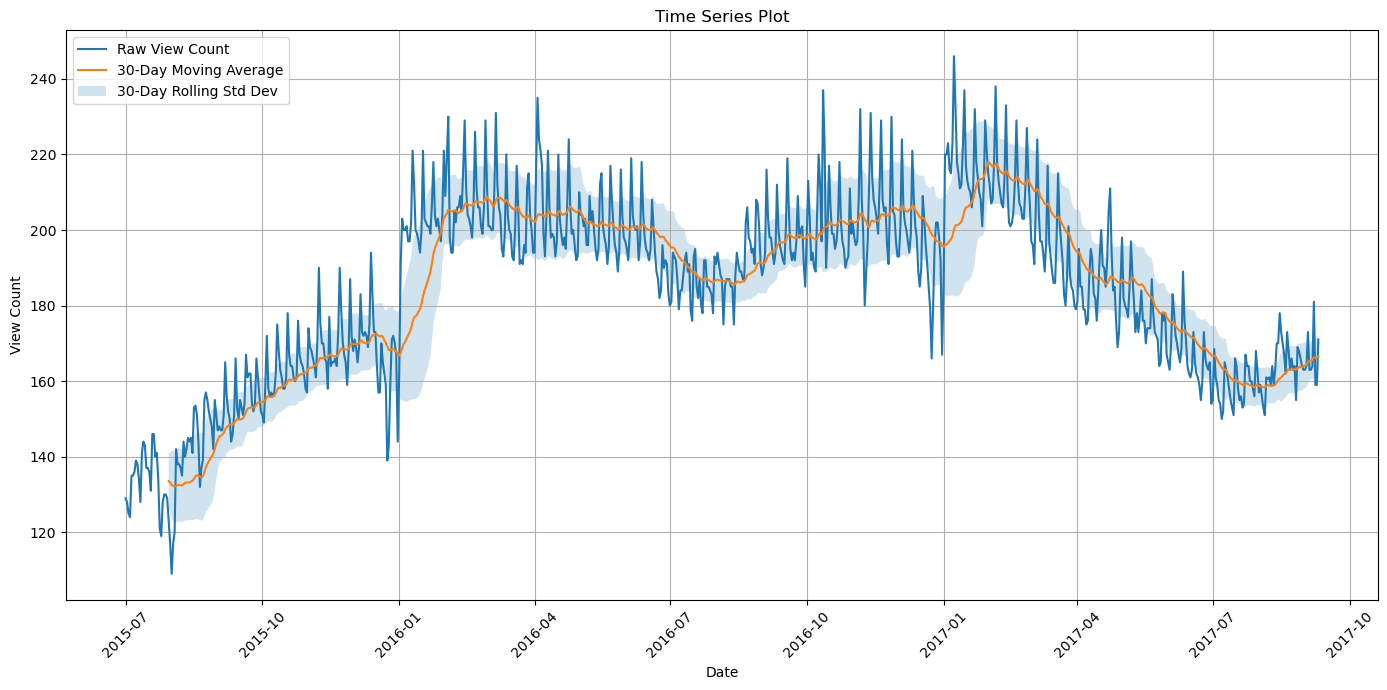

In [28]:
sum_agg_data = df.sum(axis=1)
mean_agg_data = df.mean(axis=1)
median_agg_data = df.median(axis=1)
plot_time_series(mean_agg_data, date_columns, window_sizes=[30])
plot_time_series(median_agg_data, date_columns, window_sizes=[30])

**Mean Aggregated Data**

- Rolling Mean:
    * Shows an increasing trend peaking around mid-2016, followed by a decline towards late 2016 and 2017, indicating heightened interest then a gradual decline.
- Rolling Standard Deviation:
    * Increased variability around mid-2016 suggests significant fluctuations due to outliers or extreme values.

**Median Aggregated Data**

- Rolling Mean:
    * Follows a similar trend to the mean, with an increase up to mid-2016 and a decline afterwards, indicating consistent interest.
- Rolling Standard Deviation:
    * Lower variability compared to the mean, indicating more stable viewership patterns with fewer extreme spikes, suggesting less influence from outliers.


### Autocorrelation Plot

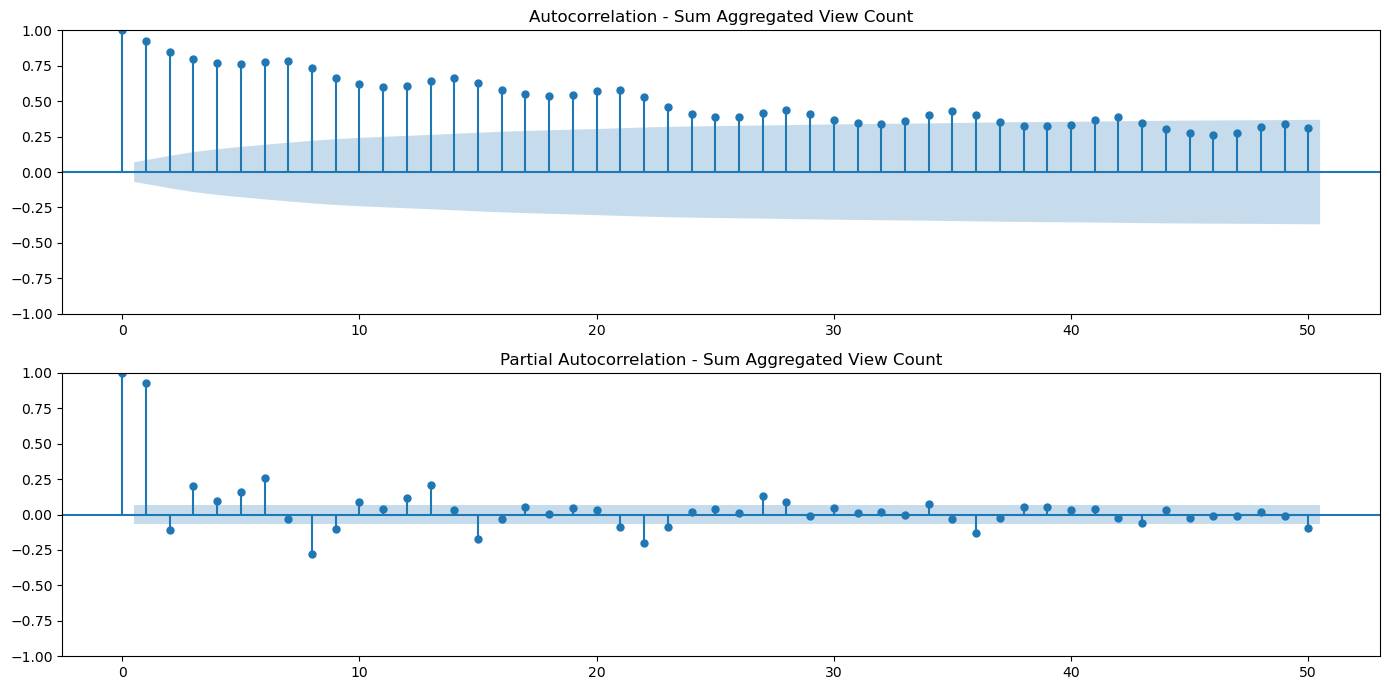

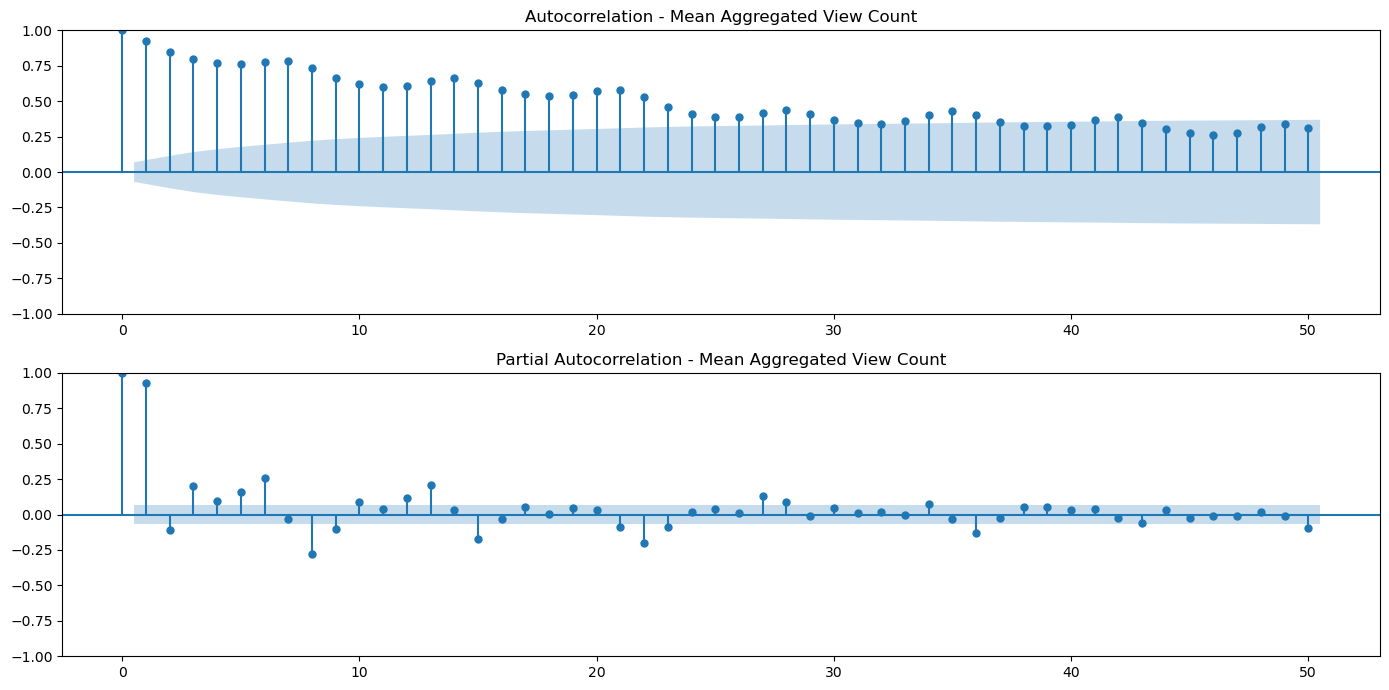

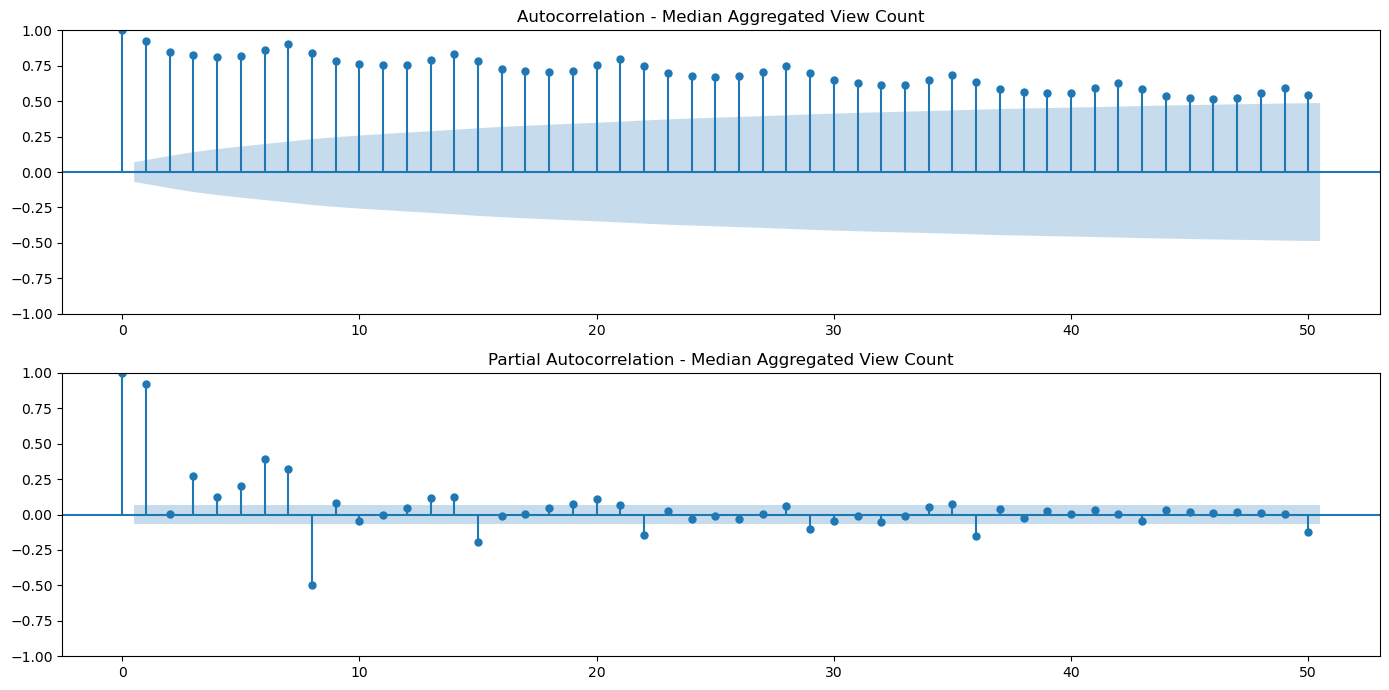

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_autocorrelation(data, lags=50, title=''):
    """
    Plots the autocorrelation and partial autocorrelation for the given data.
    
    Parameters:
        data (Series): The time series data for which to plot the autocorrelation.
        lags (int): Number of lags to display in the plot.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 7))
    
    # Autocorrelation plot
    plt.subplot(211)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.title(f'Autocorrelation - {title}')
    
    # Partial Autocorrelation plot
    plt.subplot(212)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.title(f'Partial Autocorrelation - {title}')
    
    plt.tight_layout()
    plt.show()


plot_autocorrelation(sum_agg_data, title='Sum Aggregated View Count')
plot_autocorrelation(mean_agg_data, title='Mean Aggregated View Count')
plot_autocorrelation(median_agg_data, title='Median Aggregated View Count')

### Sum Aggregated View Count
- **Autocorrelation**: The autocorrelation plot for the sum aggregated view count shows significant positive autocorrelation at various lags, gradually decreasing as the lag increases. This indicates a strong correlation between the sum of view counts and their previous values over time.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, indicating that the immediate previous value has a strong influence on the current value. Subsequent lags show diminishing partial correlations, suggesting that beyond the first lag, the influence of previous values is less pronounced but still present.

### Mean Aggregated View Count
- **Autocorrelation**: Similar to the sum aggregation, the autocorrelation plot for the mean aggregated view count shows significant positive autocorrelation, though the values are slightly lower. This suggests that the mean view counts also have a strong dependency on their past values.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, followed by smaller spikes at other lags. This pattern indicates that while the immediate previous mean view count strongly influences the current value, other lagged values also contribute but to a lesser extent.

### Median Aggregated View Count
- **Autocorrelation**: The autocorrelation plot for the median aggregated view count exhibits a similar pattern, with significant positive autocorrelation that decreases with increasing lag. This suggests that the median view counts also depend on their past values.
- **Partial Autocorrelation**: The partial autocorrelation plot shows a significant spike at lag 1, followed by smaller, less pronounced spikes at higher lags. This indicates that the immediate previous median view count strongly influences the current value, with other lagged values having a lesser impact.

### Overall Insights
- **Lagged Dependencies**: All three plots (sum, mean, and median) exhibit significant autocorrelation, confirming the presence of strong lagged dependencies in the data. This is indicative of the seasonal and trend components inherent in the view counts.
- **Model Implications**: The significant spikes at lag 1 in the partial autocorrelation plots suggest that autoregressive models (such as ARIMA) would be suitable for forecasting, as the immediate past values are highly informative of the current values.

### Seasonal Decomposition

Decompose the time series into trend, seasonal, and residual components. This can provide insights into the underlying patterns and help in selecting appropriate forecasting models.

**Using sum aggregation**:
- Comprehensive Insight: Sum aggregation gives an overall picture of the total activity, which is useful for understanding the collective behavior of view counts across all pages.
- Trend Analysis: It allows for identifying long-term trends and seasonal patterns in the total activity, which is crucial for planning and forecasting.
- Model Suitability: Seasonal decomposition of the sum helps in selecting appropriate forecasting models that can handle aggregated data effectively.

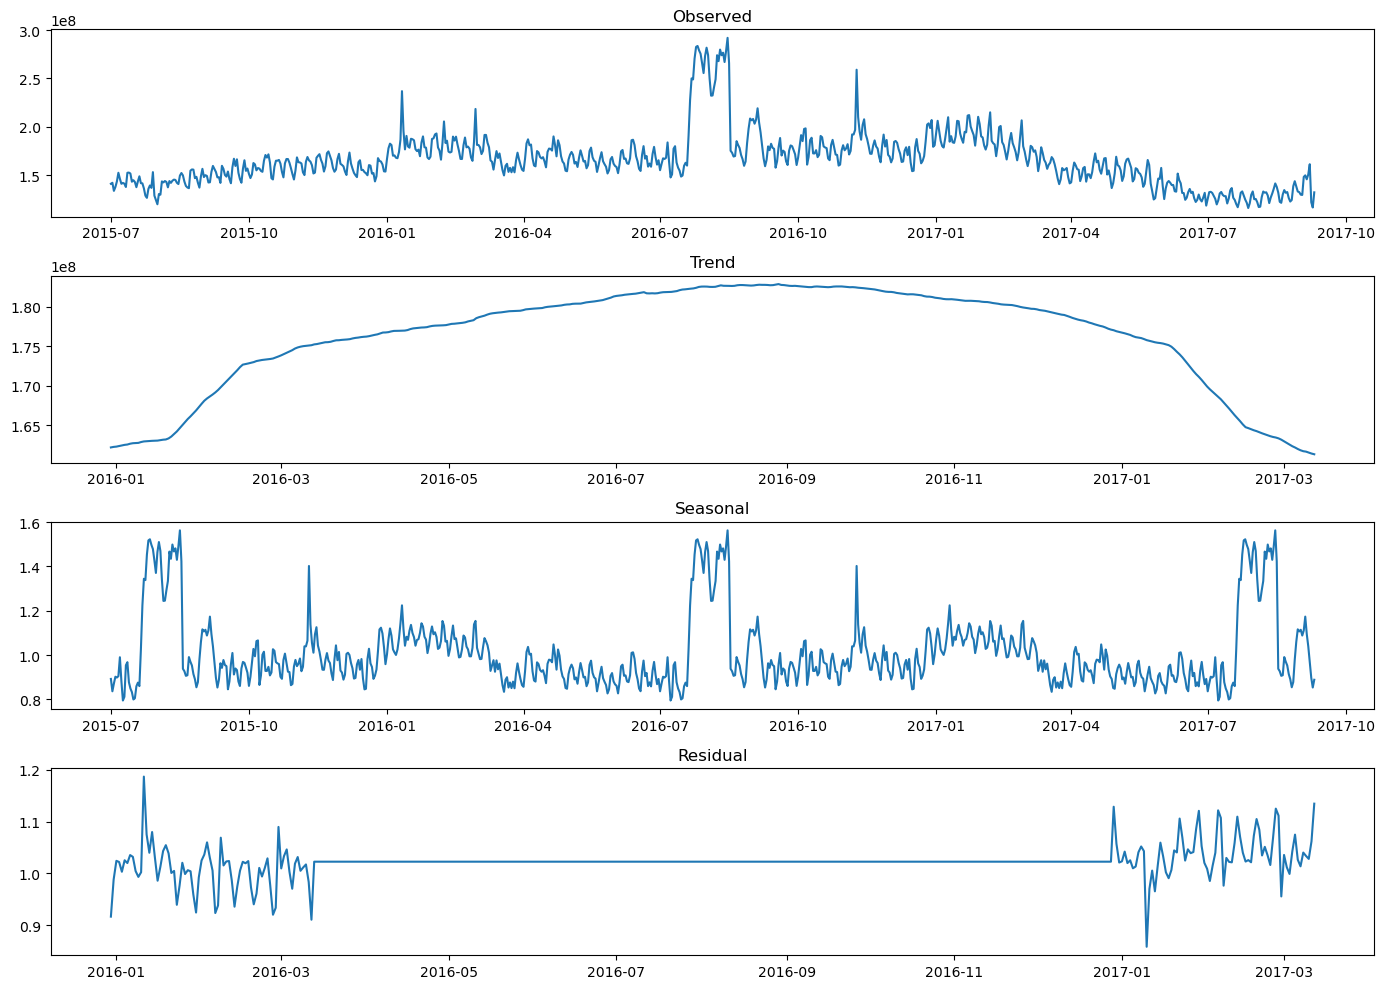

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decompose(data, model='multiplicative', freq=365):
    """
    Decomposes the time series data into trend, seasonal, and residual components and plots them.
    
    Parameters:
        data (Series): The time series data to decompose.
        model (str): The type of decomposition ('additive' or 'multiplicative').
        freq (int): The frequency of the seasonal component.
    """
    decomposition = seasonal_decompose(data, model=model, period=freq)

    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    
    plt.tight_layout()
    plt.show()

plot_seasonal_decompose(sum_agg_data, model='multiplicative')

**Observed**: The observed time series represents the actual view counts over time. It shows noticeable peaks and troughs, with significant increases around mid-2016 and subsequent declines. There are clear seasonal patterns and occasional spikes, indicating periods of higher activity.

**Trend**: The trend component shows the long-term movement of the time series. Here, the trend indicates:
- An initial increase in view counts from early 2016 until around mid-2016.
- A gradual decline from mid-2016 to early 2017.
- This suggests an overall upward trend in the first half of the period, followed by a downward trend.

**Seasonal**: The seasonal component captures the repeating patterns or cycles within the time series.
- The seasonal plot indicates regular fluctuations that repeat annually.
- There are higher values during mid-year and lower values towards the end of the year.
- This suggests a strong seasonal effect, where certain times of the year consistently see higher or lower activity.

**Residual**: The residual component represents the noise or random variation left after removing the trend and seasonal components.
- The residuals appear relatively stable for most of the period but show some spikes towards the end of the period.
- This indicates that most of the variation in the data can be explained by the trend and seasonal components, with some remaining unexplained variability.

Overall Insights
- Seasonality and Trend: The decomposition confirms strong seasonal patterns and a noticeable trend in the data. Understanding these components is crucial for accurate forecasting.
- Model Selection: The presence of significant seasonal and trend components suggests that models capable of handling seasonality (such as SARIMA or seasonal decomposition of time series forecasting models) would be appropriate.
- Residuals: Analyzing residuals can help improve model accuracy by addressing any unexplained variations. If residuals show patterns, further investigation or model refinement might be needed.

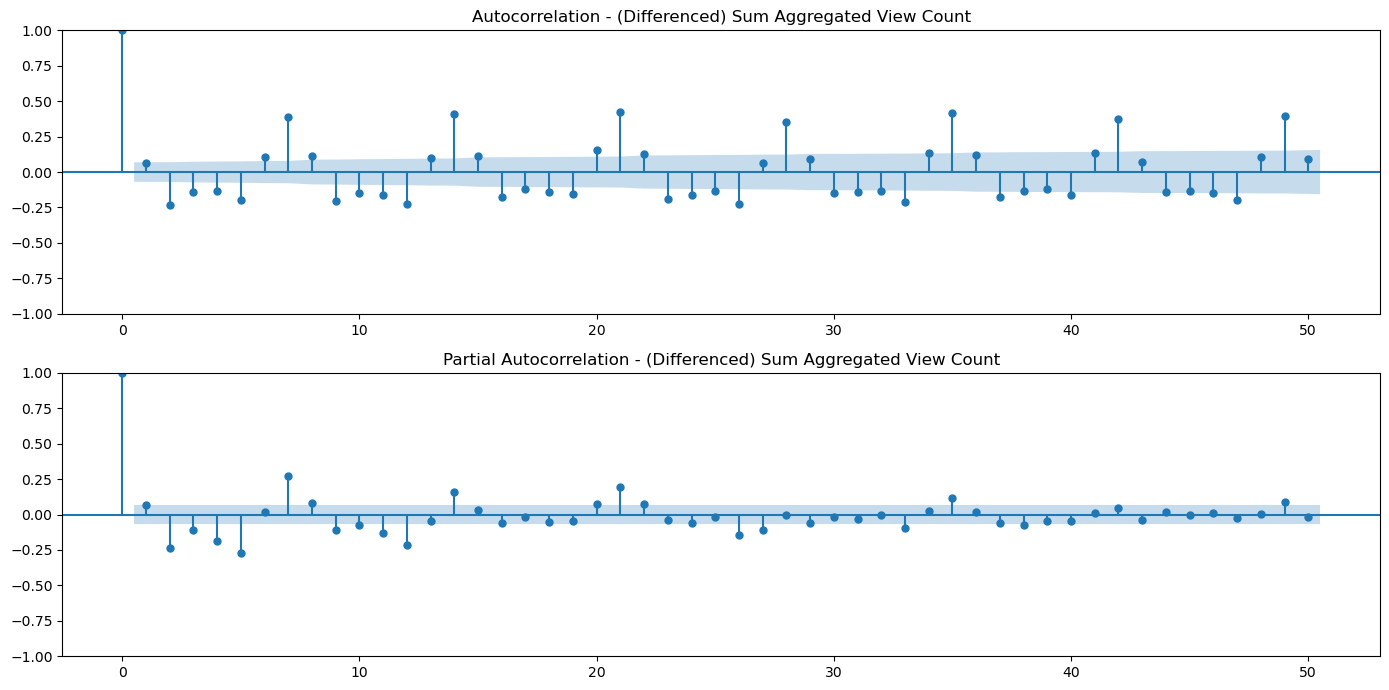

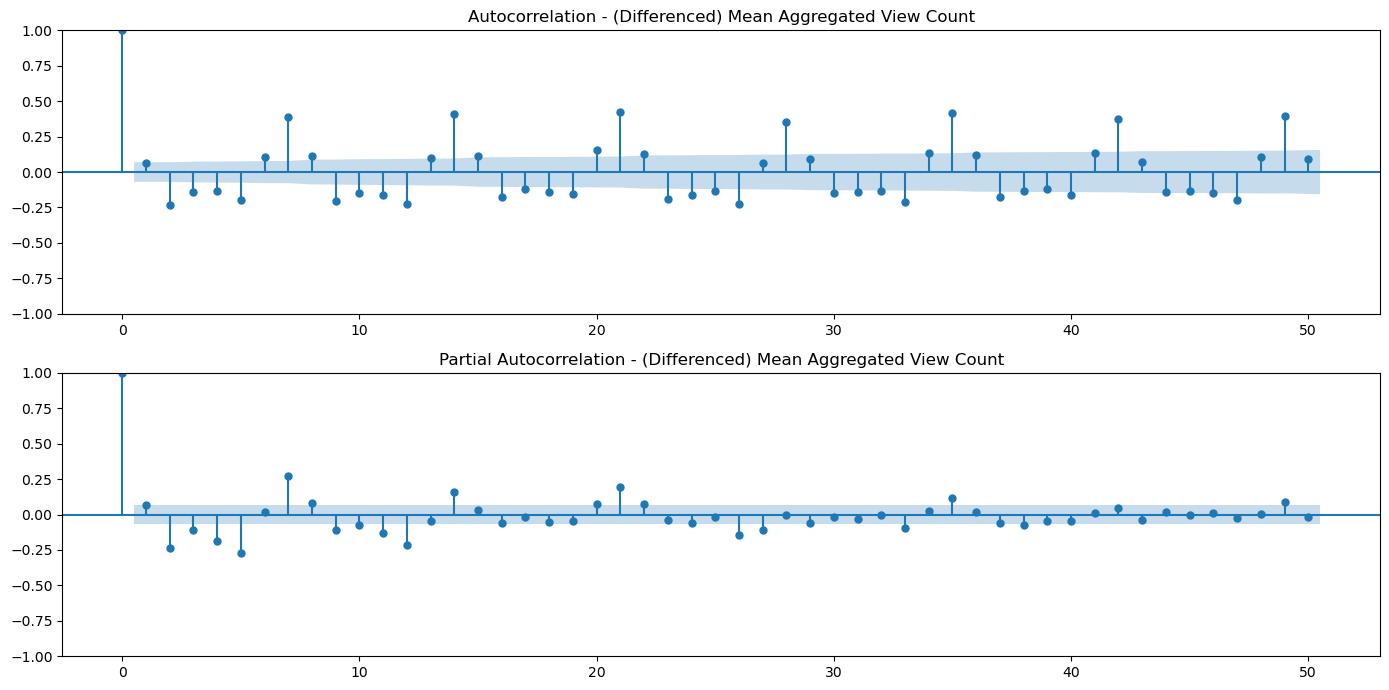

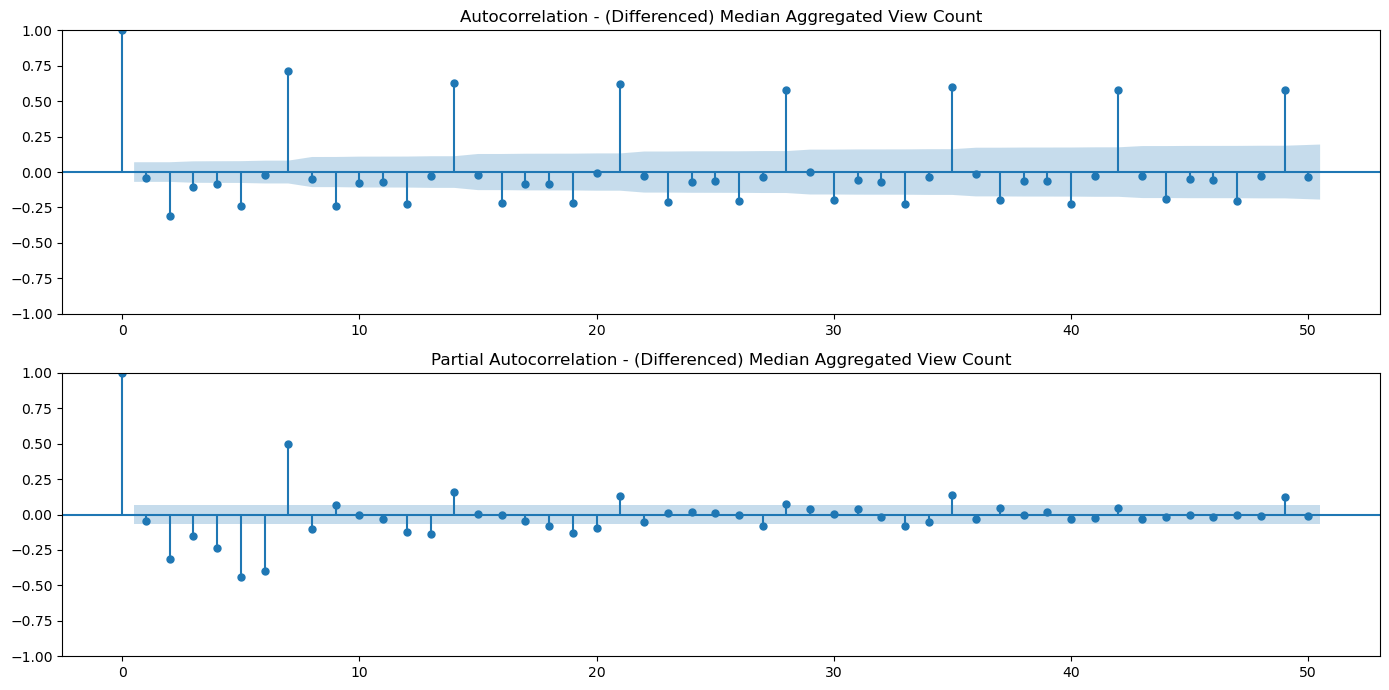

In [61]:
plot_autocorrelation(sum_agg_data.diff().dropna(), title='(Differenced) Sum Aggregated View Count')
plot_autocorrelation(mean_agg_data.diff().dropna(), title='(Differenced) Mean Aggregated View Count')
plot_autocorrelation(median_agg_data.diff().dropna(), title='(Differenced) Median Aggregated View Count')

### Stationarity Check

Let's check if our time series data is stationary. Non-stationary data can affect the performance of forecasting models. 

Let's use the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [31]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

print('Sum Aggrgated Data')
print('**********')
check_stationarity(sum_agg_data)
print('Mean Aggrgated Data')
print('**********')
check_stationarity(mean_agg_data)
print('Median Aggrgated Data')
print('**********')
check_stationarity(median_agg_data)

Sum Aggrgated Data
**********
ADF Statistic: -3.126224
p-value: 0.024672
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281
Mean Aggrgated Data
**********
ADF Statistic: -3.126224
p-value: 0.024672
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281
Median Aggrgated Data
**********
ADF Statistic: -2.030596
p-value: 0.273321
Critical Values:
   1%, -3.438750669890019
Critical Values:
   5%, -2.8652477937238703
Critical Values:
   10%, -2.56874438754281


**Non-Stationarity**: All three aggregated data sets (sum, mean, and median) are non-stationary based on the ADF test results. This means that their statistical properties (mean, variance) change over time, and they are not suitable for many time series models without transformation.

**Next Steps**: To proceed with time series modeling, transformations such as differencing or detrending will be necessary to achieve stationarity. This will allow the use of models that assume a stationary time series.

In [32]:
import numpy as np

def detect_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    outliers = np.abs(z_scores) > threshold
    return outliers

outliers = detect_outliers(sum_agg_data)
sum_agg_data[outliers]

2016-07-22    250069811.0
2016-07-24    270525905.0
2016-07-25    282644067.0
2016-07-26    283599194.0
2016-07-27    279016224.0
2016-07-28    275532138.0
2016-07-29    265962757.0
2016-07-30    255583827.0
2016-07-31    273228558.0
2016-08-01    281812005.0
2016-08-02    274286620.0
2016-08-03    250213557.0
2016-08-07    249125206.0
2016-08-08    274023177.0
2016-08-09    267897358.0
2016-08-10    279870447.0
2016-08-11    274035561.0
2016-08-12    276619155.0
2016-08-13    267005297.0
2016-08-14    278559430.0
2016-08-15    291993076.0
2016-08-16    265781223.0
2016-11-09    259040706.0
dtype: float64

Most of the outliers are concentrated in a specific period between late July 2016 and mid-August 2016. There is also a notable outlier on November 9, 2016.

**Potential Causes**: These spikes in view counts could be due to various factors such as:
- Major events or news articles that caused a surge in traffic.
- Seasonal or periodic spikes in interest.
- Anomalies or errors in data collection.

### Correlation Analysis: Check for correlations between different articles' view counts

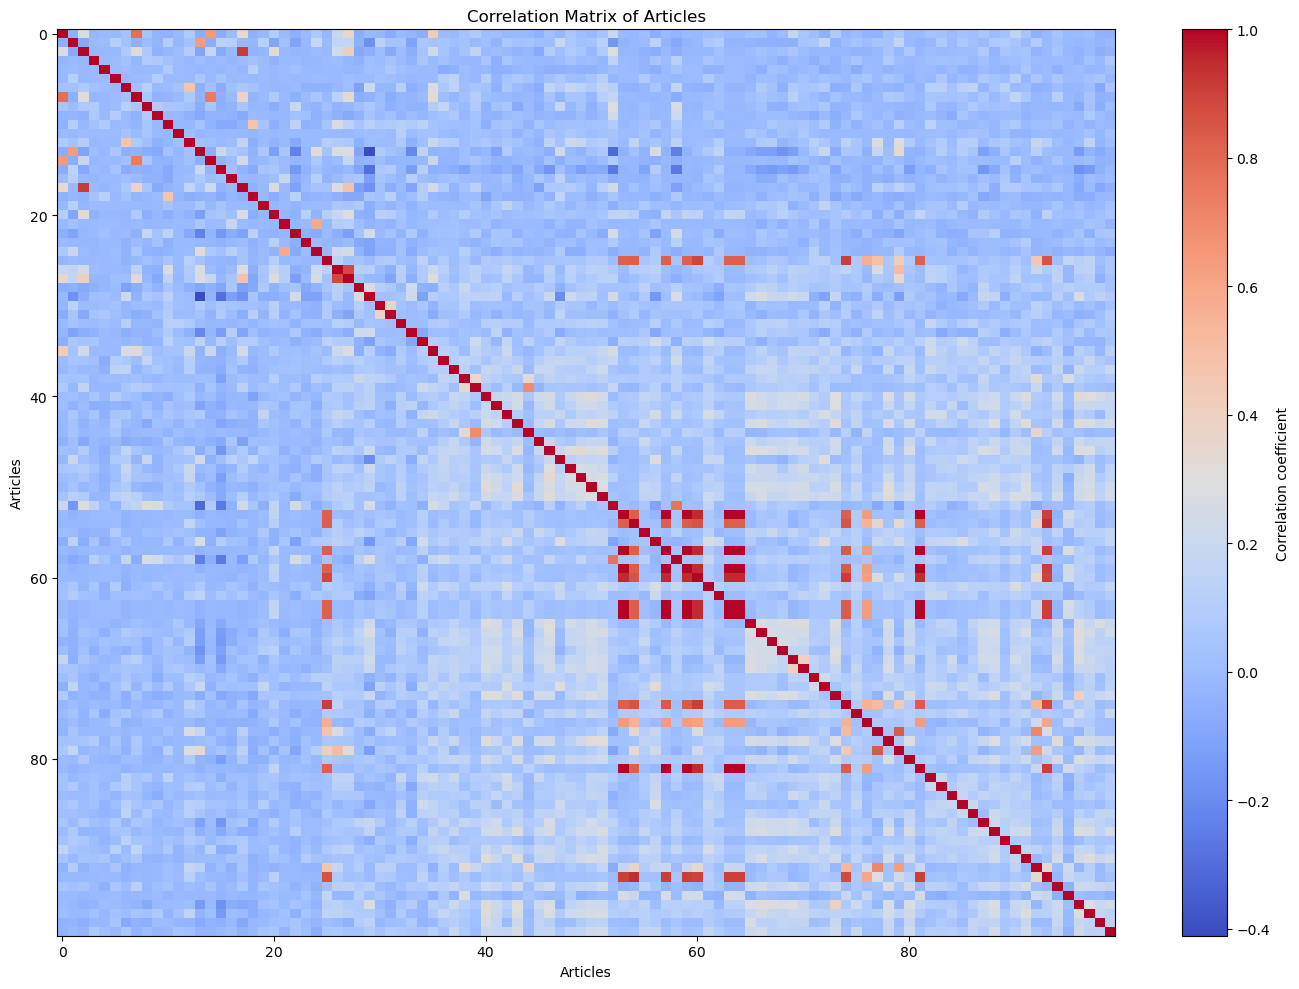

In [33]:
correlation_matrix = df.iloc[:, 11000:11100].corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix of Articles')
plt.xlabel('Articles')
plt.ylabel('Articles')
# plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90)
# plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix.index)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()